

## Predict Product Prices

### And now, to evaluate our fine-tuned open source model



In [1]:
# pip installs

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 133.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import PeftModel
import matplotlib.pyplot as plt

In [10]:
# Constants

BASE_MODEL = "Qwen/Qwen2.5-7B"
PROJECT_NAME = "pricer"
HF_USER = "jakb9ads" # your HF name here! Or use mine if you just want to reproduce my results.

# The run itself

RUN_NAME = "2025-08-06_13.43.39"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
REVISION = "6058b4fe8271bdfedf60314df3d7d00ae846192d" # or REVISION = None
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Uncomment this line if you wish to use my model
# FINETUNED_MODEL = f"ed-donner/{PROJECT_RUN_NAME}"

# Data

DATASET_NAME = f"{HF_USER}/pricer-data"
# Or just use the one I've uploaded
# DATASET_NAME = "ed-donner/pricer-data"

# Hyperparameters for QLoRA

QUANT_4_BIT = True

%matplotlib inline

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

### Log in to HuggingFace

If you don't already have a HuggingFace account, visit https://huggingface.co to sign up and create a token.

Then select the Secrets for this Notebook by clicking on the key icon in the left, and add a new secret called `HF_TOKEN` with the value as your token.


In [5]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [6]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/416 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/919k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
test[0]

{'text': 'How much does this cost to the nearest dollar?\n\nTLAPS Compatible With Toyota Tacoma Non-Factory LED LED DRL Black Housing Full LED Sequential Quad Projector Headlights With Amber Reflector\nApplication Compatible With Toyota Tacoma Models With Non-Factory LED DRL ( Daytime Running Lights ) Headlights Only ( Attention Note Will Not Fit Models With Factory LED DRL ( Daytime Running Lights ) Headlights, Hyper Blinking May Occur If Used With Other Branded Aftermarket LED Lighting ) Full LED Sequential Projector Headlights ( Attention These LED Projector Headlights Will ONLY Replace Factory OEM Halogen Style Headlights, Not Compatible With Factory Upgraded Projectors Or LED Headlights, Hyper Blinking May Occur If Used With Other Branded Aftermarket LED Lighting. For More Information Please Contact Us ) Quad-LED Projector Design With Amber Sequential\n\nPrice is $',
 'price': 389.0}

## Now load the Tokenizer and Model

In [8]:
# pick the right quantization (thank you Robert M. for spotting the bug with the 8 bit version!)

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [11]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load the fine-tuned model with PEFT
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/80.8M [00:00<?, ?B/s]

Memory footprint: 5524.0 MB


In [12]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(152064, 3584)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3584, out_features=3584, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3584, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=3584, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.

# THE MOMENT OF TRUTH!

## Use the model in inference mode

Remember, GPT-4o had an average error of \$76.  
Llama 3.1 base model had an average error of \$396.   
This human had an error of \$127.  

## Caveat

Keep in mind that prices of goods vary considerably; the model can't predict things like sale prices that it doesn't have any information about.

In [13]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [14]:
extract_price("Price is $a fabulous 899.99 or so")

899.99

In [15]:
# Original prediction function takes the most likely next token

def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [19]:
# An improved prediction function takes a weighted average of the top 3 choices
# This code would be more complex if we couldn't take advantage of the fact
# That Llama generates 1 token for any 3 digit number

top_K = 1

#def improved_model_predict(prompt, device="cuda"):
#    set_seed(42)
#    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
#    attention_mask = torch.ones(inputs.shape, device=device)
#
#    with torch.no_grad():
#        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
#        next_token_logits = outputs.logits[:, -1, :].to('cpu')
#
#    next_token_probs = F.softmax(next_token_logits, dim=-1)
#    top_prob, top_token_id = next_token_probs.topk(top_K)
#    prices, weights = [], []
#    for i in range(top_K):
#      predicted_token = tokenizer.decode(top_token_id[0][i])
#      probability = top_prob[0][i]
#      try:
#        result = float(predicted_token)
#      except ValueError as e:
#        result = 0.0
##      if result > 0:
#        prices.append(result)
#        weights.append(probability)
#    if not prices:
#      return 0.0, 0.0
#    total = sum(weights)
#    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
#    return sum(weighted_prices).item()


def improved_model_predict(prompt, device="cuda"):
    set_seed(42)

    input_ids = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        output = fine_tuned_model.generate(
            **input_ids,
            max_new_tokens=5,
            do_sample=False,
            num_return_sequences=1
        )

    generated_ids = output[0][input_ids['input_ids'].shape[1]:]
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

    import re
    match = re.search(r"\d+(\.\d+)?", generated_text)
    if match:
        result = float(match.group())
        if result > 0:
            return result  # ✅ Bara talet
    return 0.0



In [20]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $300.00 Truth: $389.00 Error: $89.00 SLE: 0.07 Item: TLAPS Compatible Wit...
2: Guess: $111.00 Truth: $11.95 Error: $99.05 SLE: 4.65 Item: Witonics Capacitor R...
3: Guess: $111.00 Truth: $57.99 Error: $53.01 SLE: 0.41 Item: EPSIRMP Mass Air Flo...
4: Guess: $35.00 Truth: $32.99 Error: $2.01 SLE: 0.00 Item: 2 Pc 4 in 1 Double B...
5: Guess: $172.00 Truth: $136.94 Error: $35.06 SLE: 0.05 Item: Can-Am Outlander 650...
6: Guess: $110.00 Truth: $116.10 Error: $6.10 SLE: 0.00 Item: OREI KVM 4K HDMI Ove...
7: Guess: $205.00 Truth: $249.97 Error: $44.97 SLE: 0.04 Item: MAXLINER Custom Fit ...
8: Guess: $165.00 Truth: $151.89 Error: $13.11 SLE: 0.01 Item: Alpinestars White X-...
9: Guess: $134.00 Truth: $110.99 Error: $23.01 SLE: 0.03 Item: SCITOO automotive re...
10: Guess: $171.00 Truth: $218.78 Error: $47.78 SLE: 0.06 Item: SchaefflerLuK DMF066...
11: Guess: $130.00 Truth: $121.99 Error: $8.01 SLE: 0.00 Item: Smart Lock,CATCHFACE...
12: Guess: $240.00 Truth: $429.95 Error: $189.95

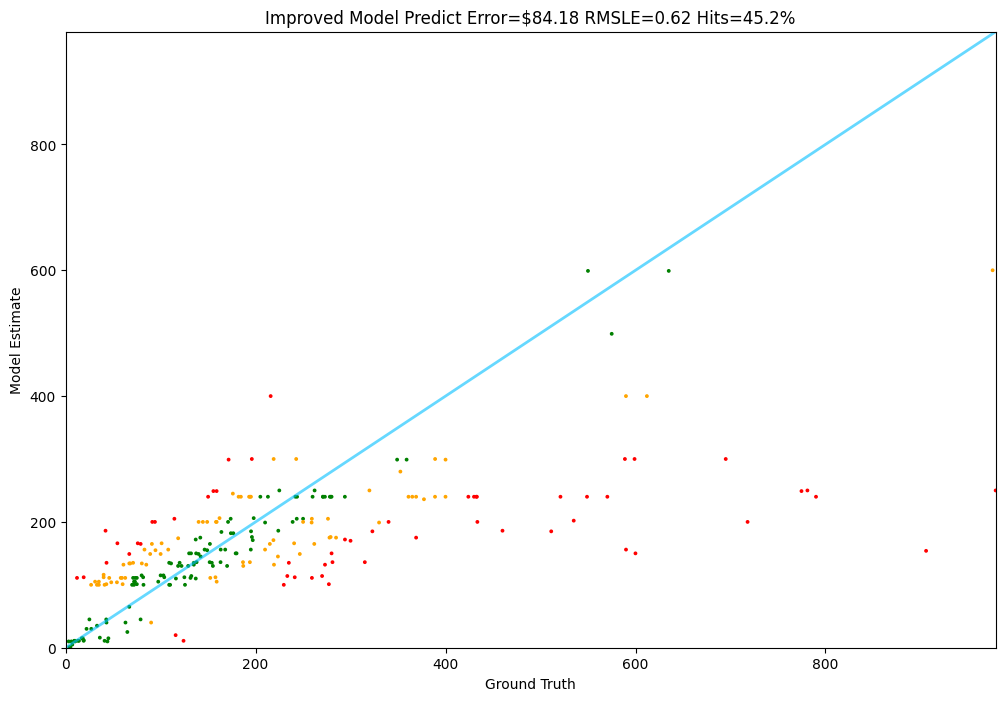

In [21]:
Tester.test(improved_model_predict, test)